Цель: Выберите любой понравившийся вам датасет по задаче классификации (https://archive.ics.uci.edu/ml/datasets.php?format=&task=clu&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) и повторите вычисления из урока.

In [1]:
import pandas as pd

from sklearn.datasets import make_classification, make_circles
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [9]:
data_path = '/Users/katush/Documents/Otus/ML/L09-SVM/AsianReligionsData/'
data = pd.read_csv(data_path+'AllBooks_baseline_DTM_Labelled.csv')  # AllBooks_baseline_DTM_Labelled

In [11]:
data.head()

,Unnamed: 0,foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,...,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
0,Buddhism_Ch1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Buddhism_Ch2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Buddhism_Ch3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Buddhism_Ch4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Buddhism_Ch5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
data['Book'] = data['Unnamed: 0'].str.split('_', expand=True)[0]

In [23]:
data['Book'].nunique()

8

In [46]:
def quality_report(prediction, actual, verbose=True):
    report_str = "Accuracy: \t {:.3f}\n" +\
                 "Precision: \t {:.3f}\n" +\
                 "Recall: \t {:.3f}\n" +\
                 "f1_score: \t {:.3f}\n"
    
    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual, average='micro')
    recall = recall_score(prediction, actual, average='micro')
    f1 = f1_score(prediction, actual, average='micro')
    
    quality_list = [acc, precision, recall, f1]
    
    if verbose:
        print("\n=== Quality Report ===")
        print(report_str.format(acc,
            precision,
            recall,
            f1
        ))
        print("======================\n")
    
    return quality_list

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Unnamed: 0', 'Book'], axis=1),
    data['Book'],
    test_size=0.3,
    stratify=data['Book'],
    random_state=0)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
model_LogR = LogisticRegression()
model_LogR.fit(X_train_scaled, y_train)
pred_LR = model_LogR.predict(X_test_scaled)

qr_lr = quality_report(pred_LR, y_test.values)


=== Quality Report ===
Accuracy: 	 0.870
Precision: 	 0.870
Recall: 	 0.870
f1_score: 	 0.870




In [49]:
model_svc = svm.SVC()
model_svc.fit(X_train_scaled, y_train)
pred_svc = model_svc.predict(X_test_scaled)

qr_svc = quality_report(pred_svc, y_test.values)


=== Quality Report ===
Accuracy: 	 0.322
Precision: 	 0.322
Recall: 	 0.322
f1_score: 	 0.322




Поскольку результат модели SVM из коробки оказался намного хуже Логистической регрессии из коробки, то подберем парамтеры, используя GridSearch - будем варьировать:
- **kernel** (‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable - default=’rbf’): kernel parameters selects the type of hyperplane used to separate the data. Using ‘linear’ will use a linear hyperplane (a line in the case of 2D data). ‘rbf’ and ‘poly’ uses a non linear hyper-plane.
- **gamma**: is a parameter for non linear hyperplanes, the higher the gamma value it tries to exactly fit the training data set.
- **C**: default=1.0: is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly.


- 'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
- 'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
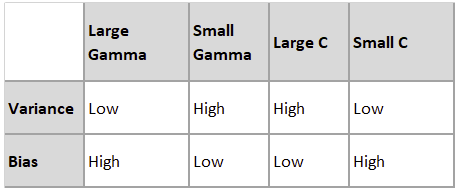

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769
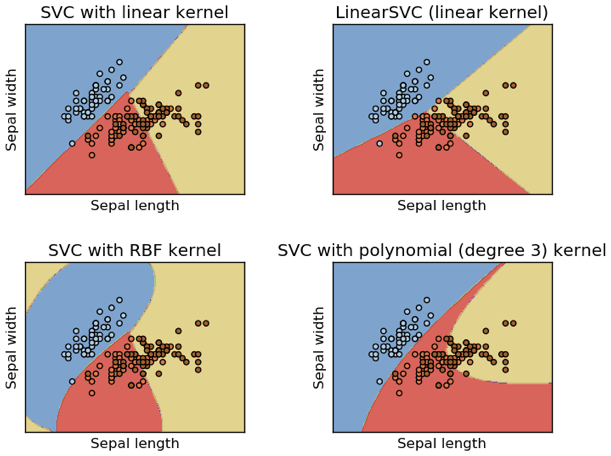

In [59]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svm_model = GridSearchCV(svm.SVC(), params_grid, cv=5)
svm_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [60]:
print('Best score for training data:', svm_model.best_score_,"\n") 
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best score for training data: 0.7288135593220338 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



In [61]:
final_model = svm_model.best_estimator_
pred_svc_best = final_model.predict(X_test_scaled)
qr_svc = quality_report(pred_svc_best, y_test.values)


=== Quality Report ===
Accuracy: 	 0.836
Precision: 	 0.836
Recall: 	 0.836
f1_score: 	 0.836


